# Clustering & Dimensionality Reduction Code Tutorial

<b><u>[목적]</u></b>
- Unsupervised Learning을 활용하여 고효율 군집을 찾아보자
- 결국 우리가 원하는 것은 X's의 조합으로 고효율 Y를 도출하는 것
- Clustering의 결과를 Dunn Index & Silhouette Score 뿐만 아니라 차원 축소를 통하여 시각화를 진행해봄
- 특정 공정(특정 변수)에서 실험을 진행할 때 최적의 X's 조합을 찾기 적합한 분석 기법

<b><u>[Process]</u></b>
- Data Path = https://github.com/GonieAhn/Data-Science-online-course-from-gonie/tree/main/Data%20Store
- Define X's & Y
- Clustering
- Dimensionality Reduction
- Low & High Cluster 도출
- T-Test를 활용하여 Low & High Cluster를 구분 짓는 X's를 찾아냄
- X's 최적 조합 도출

<b><u>[주의]</u></b>
- Clustering은 기본적으로 Data가 많을때 시간이 굉장히 오래걸림
    - Distance Matrix를 만들고 행렬계산을 하는 알고리즘이 많음

In [1]:
import os
import gc
import re
from scipy import stats
import pickle
import joblib
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
%%time
# Data Load 
data = pd.read_csv("../Data Store/TOY_DATA.csv")
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 355)
Wall time: 243 ms


<b><u>[Data Selection]</u></b>
- Domain Knowlege를 활용한 Feature Selection
    - 특정 공정이나 Biz에 맞는 변수들을 선택하여 진행함
- 특정 변수들의 최적 레시피를 찾기 위함

In [3]:
# Call Inspection Variable
sele_col = ["X23","X22","X21","X254","X247","X246","X245",
            "X244","X243","X242","X241","X20","X19","X253",
            "X18","X17","X6","X5","X4"]
# Y Append --> X1 X2 X3는 Y에 가까운 특성이기 때문에 Y에 넣어봄 --> 이게 Domain Knowlege
sele_col = sele_col + ['Y', 'X1', 'X2', 'X3']

In [4]:
# Data Remake
data = data[sele_col]
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 23)


In [5]:
# Cleaning data
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 23)


<b><u>[Data 주의]</u></b>
- Clustering의 경우 Node간 (데이터간) 모든 Distance를 계산해야하기 때문에 계산량이 굉장히 큼
- 따라서 빅데이터의 경우 샘플링을 통하여 간소화하는 작업이 필요함
- Tutorial에서는 큰 데이터가 아니기 때문에 모든 데이터를 사용하여 구함
    - 데이터가 클 때는 1/5 샘플링, 1/2 샘플링 등 데이터 샘플링을 추천함
    - 특히 Spectral Clustering은 데이터 많아지면 그냥 안돌아감
    - 내가 해봤음 ~ 

In [6]:
'''
# 1/5 Sampling Code
sampling_idx = list(range(0, data.shape[0], 5))
data = data.iloc[sampling_idx, :]
data.reset_index(inplace=True, drop=True)
print(">>>> Data Shape : {}".format(data.shape))
'''
# 
X = data.iloc[:, :-4]
X.describe()

,X23,X22,X21,X254,X247,X246,X245,X244,X243,X242,X241,X20,X19,X253,X18,X17,X6,X5,X4
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,0.303478,0.156455,0.330254,0.399069,0.230505,0.315695,0.312343,0.398490,0.315149,0.232181,0.285429,0.215613,0.228056,0.189986,0.024270,0.030962,0.535524,0.353918,0.387527
std,0.179037,0.130945,0.148218,0.160676,0.200695,0.233786,0.110788,0.162579,0.235028,0.108039,0.151567,0.162740,0.051366,0.047148,0.020476,0.022429,0.126671,0.131207,0.145952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151529,0.060743,0.222222,0.257143,0.000000,0.087248,0.200000,0.285714,0.081081,0.173621,0.200000,0.058824,0.207792,0.161290,0.014766,0.022140,0.449706,0.264666,0.289209
50%,0.269097,0.114707,0.333333,0.428571,0.230769,0.335570,0.400000,0.428571,0.337838,0.224587,0.266667,0.235294,0.233766,0.177419,0.024565,0.029520,0.517700,0.336573,0.366016
75%,0.432866,0.216830,0.444444,0.542857,0.384615,0.456376,0.400000,0.428571,0.459459,0.285634,0.400000,0.294118,0.259740,0.225806,0.033555,0.040590,0.608703,0.425116,0.469507
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b><u>[Dimensionality Reduction]</u></b>
- PCA 장단점
    - 시간이 많이 걸리지 않음
    - Plotting이 안이쁨
    - cumulative lamba가 80퍼센트를 넘지 못하면 데이터의 분포에 대한 Plotting의 의미가 사라짐 
        - 80퍼센트의 기준은 그냥 내맘 ~ 
- T-SNE 장단점
    - 복잡한 데이터를 잘 표현할 수 있음
    - Plotting이 이쁨
    - 시간이 오래 걸림

In [7]:
%%time
# Select Embedding Method
# First, You choice PCA, but you should Check cumulative lamba (recommand over the 80%)
# If cumulative lamba under the 80%, you can choice TSNE !
method = 'T-SNE'

if method == 'PCA':
    print("PPPPCCCCAAAA")
    pca = PCA(n_components=2).fit(X)
    X_PCA = pca.fit_transform(X)
    X_EMM = pd.DataFrame(X_PCA, columns=['AXIS1','AXIS2'])
    print(">>>> PCA Variance : {}".format(pca.explained_variance_ratio_))

else:
    print("TTTTSSSSSNNNNNEEEEE")
    # TSNE
    X_TSNE = TSNE(n_components=2, n_iter=700, n_jobs=-1).fit_transform(X)
    X_EMM = pd.DataFrame(X_TSNE, columns=['AXIS1','AXIS2'])
    print("T-SNE FINISH ~ ")

TTTTSSSSSNNNNNEEEEE
T-SNE FINISH ~ 
Wall time: 11 s


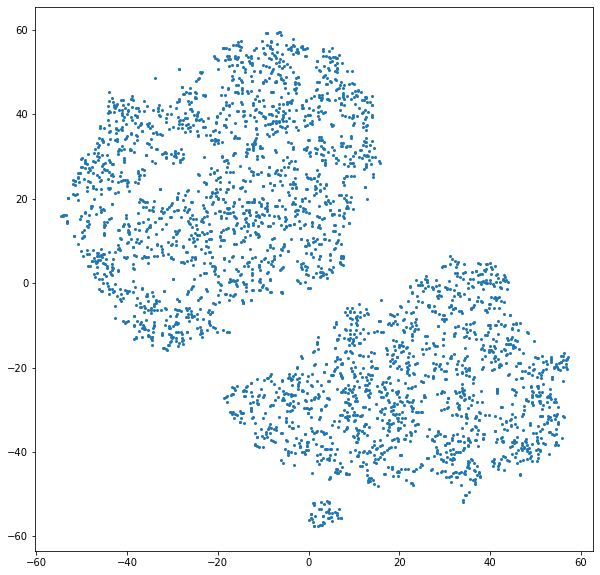

In [10]:
# 분포 Plotting
plt.figure(figsize=(10,10))
plt.scatter(X_EMM.iloc[:,0], X_EMM.iloc[:,1], s=4)
plt.show()

<b><u>[Clustering]</u></b>
- HDBSCAN의 경우 최소 Cluster가 가져야할 개수를 Hyperparameter로 사용함
- 나머지 K-means, Spectral의 경우 몇개의 클러스터를 만들 것인지에 대해 Hyperparameter를 사용함
- Spectral는 빅데이터에 시간이 너무 오래걸림
    - 이번 Tutorial은 데이터 사이즈가 크지 않기 때문에 Spectral 사용
    - 개인적으로 제일 좋아하는 알고리즘임 ^____^

>>>> Cluster 3, Silhouette Score 0.2615688985741623


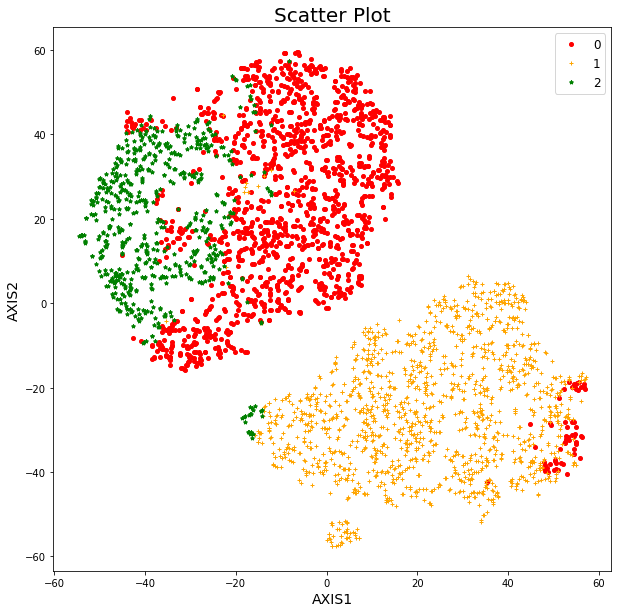

---------------------------------------------------------------------------------------------------
>>>> Cluster 4, Silhouette Score 0.20753484064525926


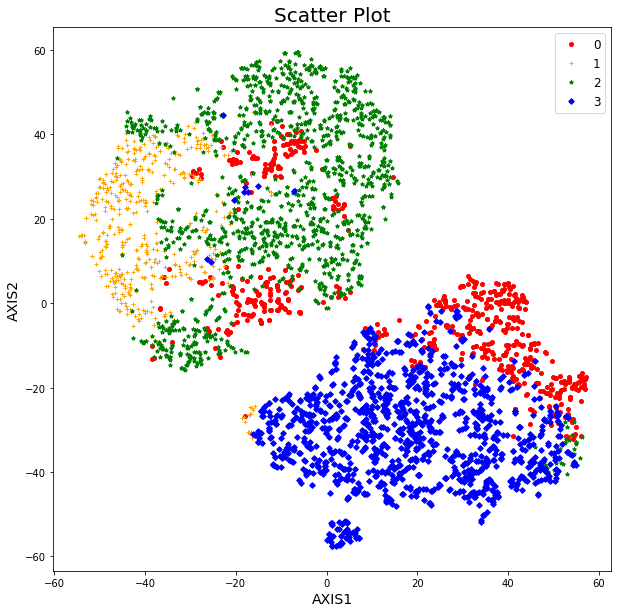

---------------------------------------------------------------------------------------------------
>>>> Cluster 5, Silhouette Score 0.18289504420461453


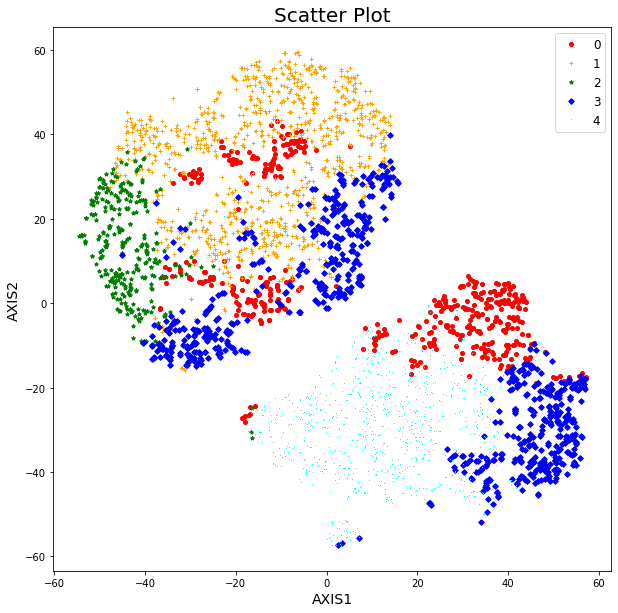

---------------------------------------------------------------------------------------------------
>>>> Cluster 6, Silhouette Score 0.17398139470358961


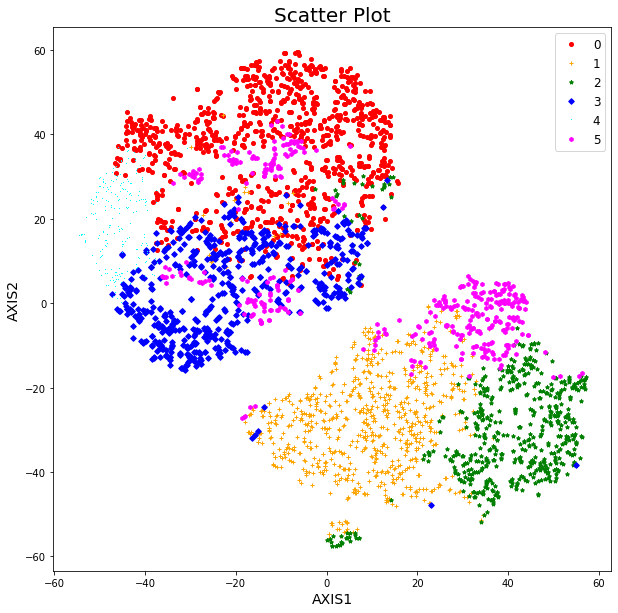

---------------------------------------------------------------------------------------------------
>>>> Cluster 7, Silhouette Score 0.15577018094424863


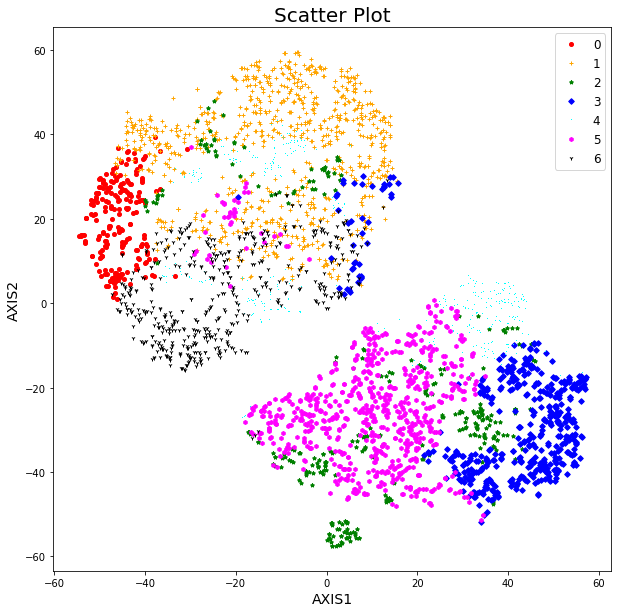

---------------------------------------------------------------------------------------------------
>>>> Cluster 8, Silhouette Score 0.1403187600802722


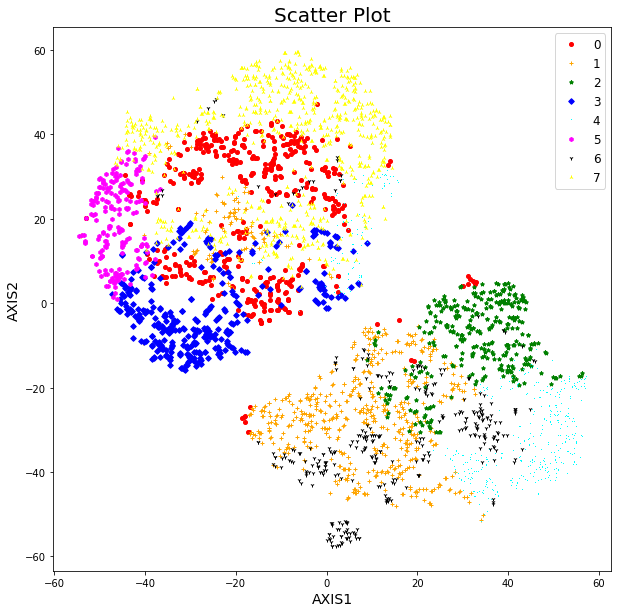

---------------------------------------------------------------------------------------------------
>>>> Cluster 9, Silhouette Score 0.13734436062233338


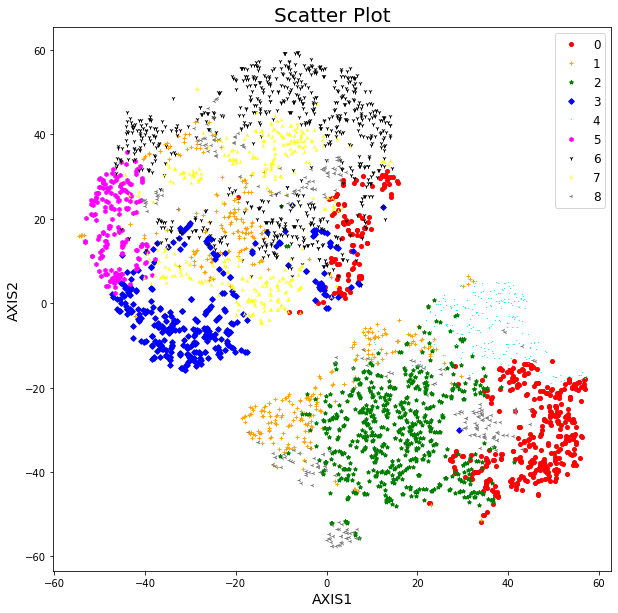

---------------------------------------------------------------------------------------------------
>>>> Cluster 10, Silhouette Score 0.14445351595671396


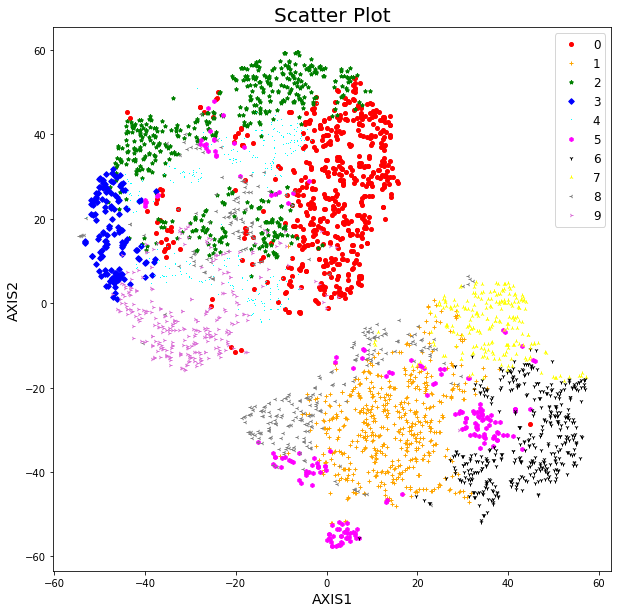

---------------------------------------------------------------------------------------------------
Wall time: 25.4 s


In [11]:
%%time
# Clustering
c_method = 'Spectral'

# You Can Select 'HDBSCAN', 'K-means', 'Spectral'
if c_method == 'HDBSCAN':
    range_list = [2000, 1500, 1300, 1000, 800, 600, 500]
else:
    range_list = list(range(3,11))

for cluster in range_list:
    
    if c_method == 'HDBSCAN':
        Cluster = hdbscan.HDBSCAN(min_cluster_size=cluster, min_samples=7,
                                  approx_min_span_tree=False,
                                  algorithm='best', gen_min_span_tree= True, 
                                  core_dist_n_jobs=-1)
        labels = Cluster.fit_predict(X)
    
    elif c_method == 'K-means':
        Cluster = KMeans(n_clusters=cluster, n_jobs=-1).fit(X)
        labels = Cluster.predict(X)
    
    # Too many Time
    elif c_method == 'Spectral':
        Cluster = SpectralClustering(n_clusters=cluster, n_init=20, n_jobs=-1).fit(X) 
        labels = Cluster.labels_ 
    else:
        ("Error !!! Check Algorithm Name")

    data['{} label'.format(cluster)] = labels
    score = silhouette_score(X, labels)
    print(">>>> Cluster {}, Silhouette Score {}".format(cluster, score))

    labels = pd.DataFrame(labels, columns=['labels'])
    plot_data = pd.concat([X_EMM, labels], axis=1)
    groups = plot_data.groupby('labels')

    mar = ['o', '+', '*', 'D', ',', 'h', '1', '2', '3', '4', 's', '<', '>']
    colo = ['red', 'orange', 'green', 'blue', 'cyan', 'magenta', 'black', 'yellow', 'grey', 'orchid', 'lightpink']

    fig, ax = plt.subplots(figsize=(10,10))
    for j, (name, group) in enumerate(groups):
        ax.plot(group['AXIS1'], 
                group['AXIS2'], 
                marker=mar[j],
                linestyle='',
                label=name,
                c = colo[j],
                ms=4)
        ax.legend(fontsize=12, loc='upper right') # legend position
    plt.title('Scatter Plot', fontsize=20)
    plt.xlabel('AXIS1', fontsize=14)
    plt.ylabel('AXIS2', fontsize=14)
    plt.show()
    print("---------------------------------------------------------------------------------------------------")

    gc.collect()

In [12]:
# Label 정보 데이터 저장
data.to_excel("./{}_result.xlsx".format(c_method))
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 31)


<b><u>[Low & High 효율 Cluster 도출]</u></b>
- 각 cluster 마다 y_list의 평균을 확인함
- Low cluster와 Hight cluster의 차이가 가장 큰 조합을 도출함

In [13]:
y_list = ['Y', 'X1', 'X2', 'X3']
data['Y'].mean()

0.7652157527074294

In [14]:
# Cluster Diff Display
n_of_cluster = len(range_list)
tmp = data.iloc[:, -n_of_cluster:]
for j in range(n_of_cluster):
    tmp_Eff = []
    print("Cluster {}".format(tmp.columns[j]))
    for k in sorted(list(set(tmp.iloc[:,j]))):
        cl_idx = np.where(tmp.iloc[:,j] == k)[0]
        print("Label {}, cnt {}".format(k, len(cl_idx)))
        for x in y_list:
            print(" {} : {} ".format(x, data[x].iloc[cl_idx].mean()))
            tt = 'Y'
            if x == '{}'.format(tt):
                tmp_Eff.append(data[x].iloc[cl_idx].mean())
        print("  ")
    print("MAX {} : {}".format(tt, max(tmp_Eff)))
    print("MIN {} : {}".format(tt, min(tmp_Eff)))
    print("Full Diff : {}".format(max(tmp_Eff) - min(tmp_Eff)))
    print("------------------------------------------------------")
 

Cluster 3 label
Label 0, cnt 1399
 Y : 0.7444664019614005 
 X1 : 84.84319871336666 
 X2 : 11.041956325947108 
 X3 : 0.7050587698355973 
  
Label 1, cnt 1501
 Y : 0.765484420326451 
 X1 : 84.59406415722852 
 X2 : 11.078482944703527 
 X3 : 0.7058030972684869 
  
Label 2, cnt 600
 Y : 0.8129242053700002 
 X1 : 84.967665 
 X2 : 11.046548999999992 
 X3 : 0.706982278333333 
  
MAX Y : 0.8129242053700002
MIN Y : 0.7444664019614005
Full Diff : 0.06845780340859975
------------------------------------------------------
Cluster 4 label
Label 0, cnt 618
 Y : 0.7493826208155343 
 X1 : 84.62865517799355 
 X2 : 11.064801294498375 
 X3 : 0.705624601941748 
  
Label 1, cnt 484
 Y : 0.8139339044958678 
 X1 : 84.9712111570248 
 X2 : 11.045873966942144 
 X3 : 0.7070435061983468 
  
Label 2, cnt 1244
 Y : 0.7498692010257234 
 X1 : 84.8671098874598 
 X2 : 11.041966800643092 
 X3 : 0.7051153030546627 
  
Label 3, cnt 1154
 Y : 0.769805354384749 
 X1 : 84.61929332755629 
 X2 : 11.077965597920283 
 X3 : 0.7058

<b><u>[X's 조합 찾기]</u></b>
- Spectral의 경우 Hyperparameter K=9 일때 Y에 대한 GAP이 가장 큰 Cluster들이 발생함
    - Cluster Label 0 (Low Y) : AVG 0.6974
        - 효율이 낮은 군집을 찾은 것
    - Cluster Label 5 (High Y) : AVG 0.8211
        - 효율이 높은 군집을 찾은 것
- Y 값에 100을 곱하면 효율 차이는 약 12% 차이가 남
- Low Cluster와 High Cluster의 차이나는 X는 p-value를 통하여 산출함
    - Low Cluster와 High Cluster를 구분 짓는 X's를 찾기위함
    - Cluster 간 분포의 차이가 없으면 분석할 필요도 없음
- 산출된 X를 Box plot를 활용하여 차이를 시각화함

In [16]:
c_min = data[data['9 label'] == 0]
c_max = data[data['9 label'] == 5]

In [19]:
# Checking
for i in y_list:
    print("{} : Max : {}, Min : {}".format(i, round(np.mean(c_max[i]),5), round(np.mean(c_min[i]), 5)))
print("# of MAX Cluster instance : {}".format(c_max.shape[0]))
print("# of MIN Cluster instance : {}".format(c_min.shape[0]))

Y : Max : 0.82119, Min : 0.69743
X1 : Max : 85.02171, Min : 84.55563
X2 : Max : 11.04217, Min : 11.05758
X3 : Max : 0.7072, Min : 0.70422
# of MAX Cluster instance : 173
# of MIN Cluster instance : 450


In [20]:
# P_Value Calcul
name_1 = []
p_value_1 = []
for column in c_max.columns[:X.shape[1]]:
    tTest = stats.ttest_ind(c_max[column], c_min[column], equal_var=False)
    name_1.append(column)
    p_value_1.append(round(tTest[1], 4))

Feature = pd.DataFrame()
Feature['Name'] = name_1
Feature['P_Value'] = p_value_1

In [21]:
Feature

,Name,P_Value
0,X23,0.0000
1,X22,0.0000
2,X21,0.0000
3,X254,0.0000
4,X247,0.0000
5,X246,0.0000
6,X245,0.0000
7,X244,0.0000
8,X243,0.0000
9,X242,0.0000


In [22]:
targets = list(Feature['Name'][Feature['P_Value'] <= 0.0001])
targets

['X23',
 'X22',
 'X21',
 'X254',
 'X247',
 'X246',
 'X245',
 'X244',
 'X243',
 'X242',
 'X241',
 'X253',
 'X18']

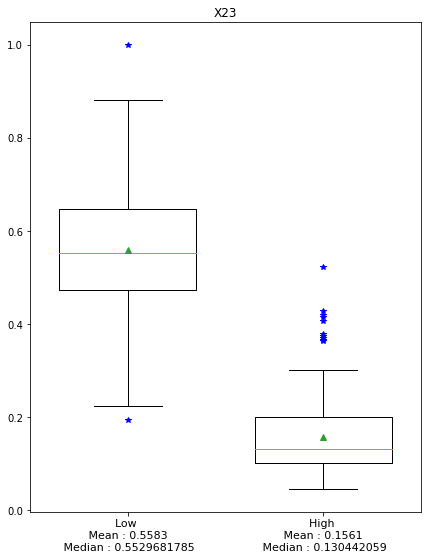

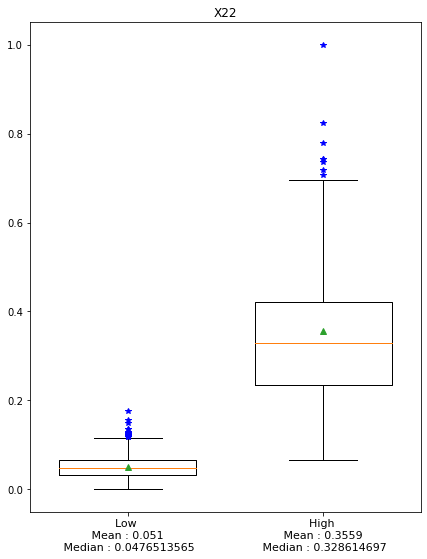

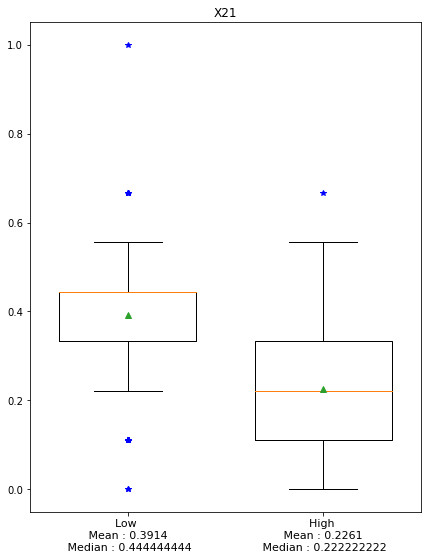

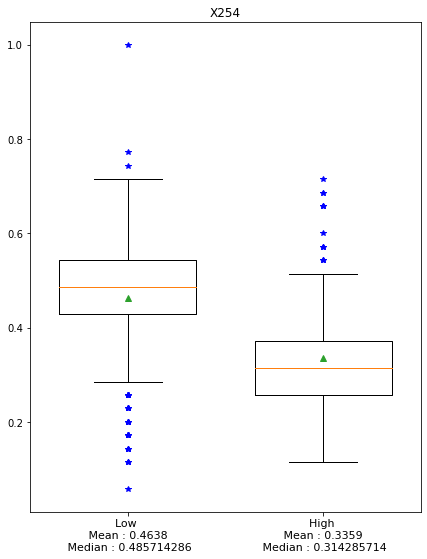

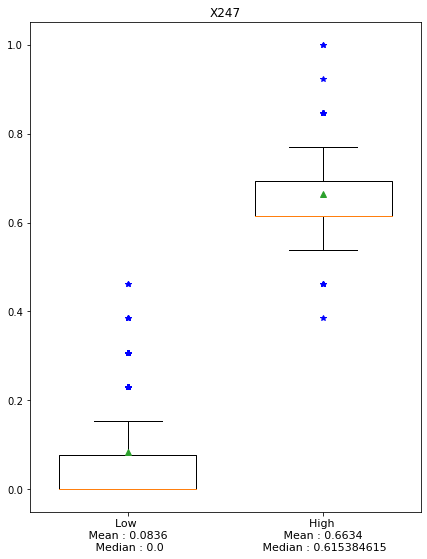

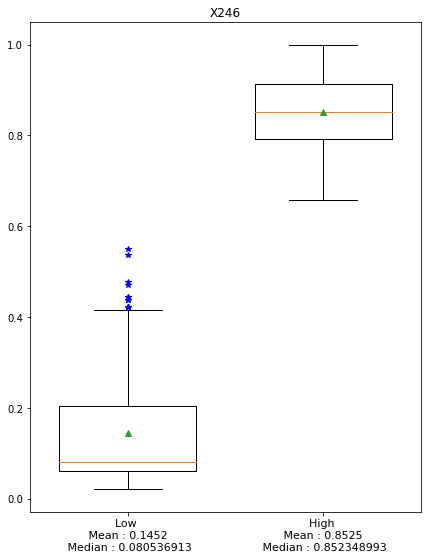

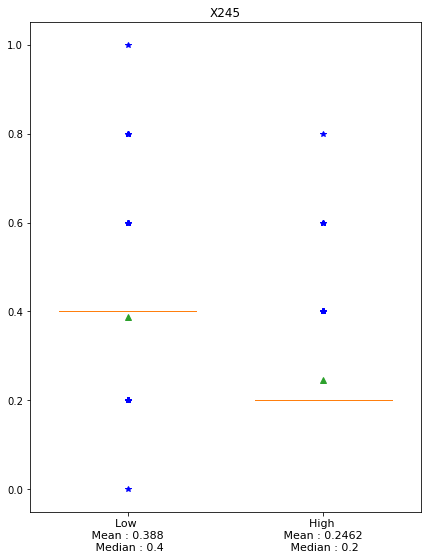

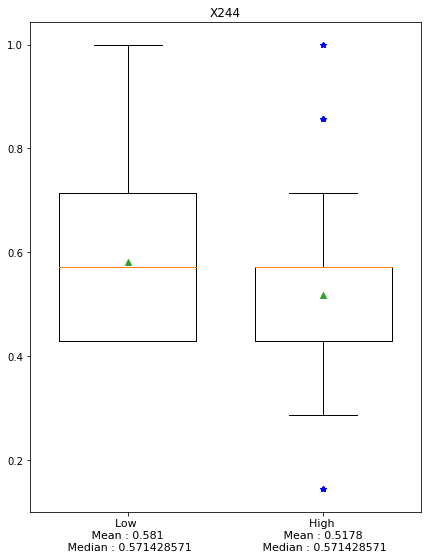

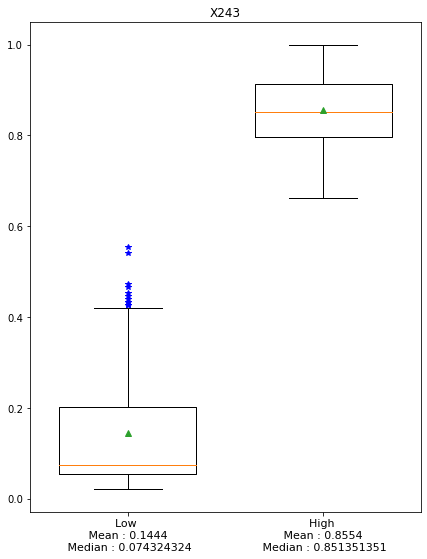

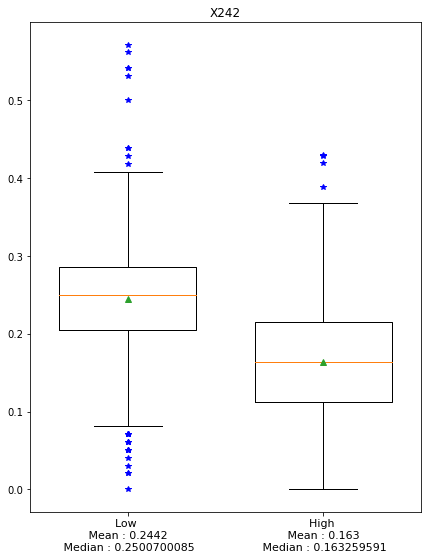

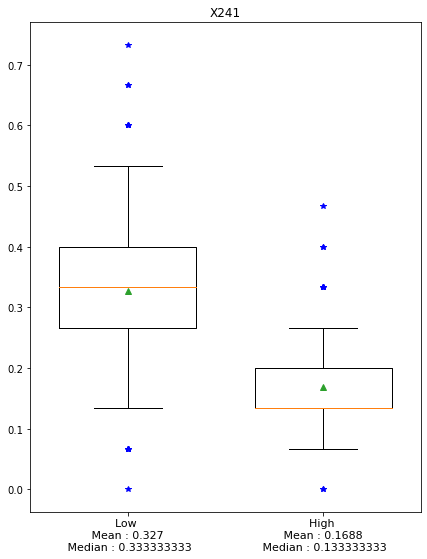

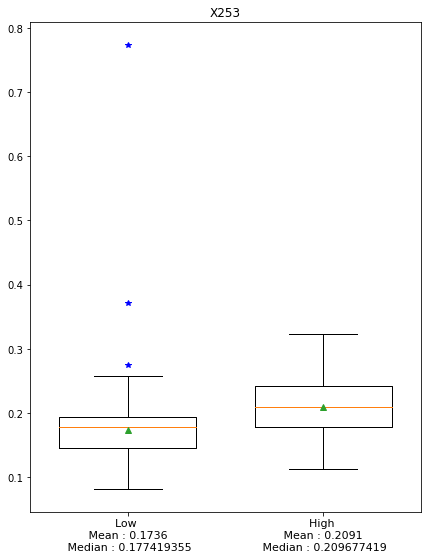

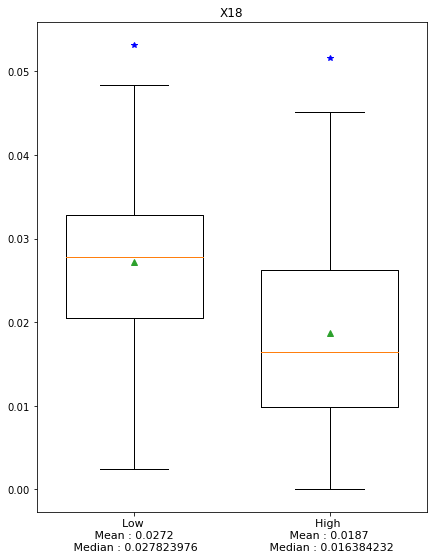

In [30]:
for target in targets:
    box_list = [[c_min[target], c_max[target]]]
    
    plt.figure(figsize=(7,9))
    plt.title(target)
    plt.boxplot(box_list[0], sym='b*', showmeans=True, widths=0.7)
    plt.xticks([1, 2],
               ['Low \n Mean : {} \n Median : {}'.format(round(np.mean(box_list[0][0]), 4), np.median(box_list[0][0])),
                'High \n Mean : {} \n Median : {}'.format(round(np.mean(box_list[0][1]), 4), np.median(box_list[0][1]))], fontsize=11)
    plt.show()